In [1]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
#import functions as fun

In [9]:
scens = ['rcp45','rcp85']
mods = ['bcc-csm1-1','CanESM2','CCSM4','CNRM-CM5','CSIRO-Mk3-6-0','GFDL-CM3','GISS-E2-R','HadGEM2-ES','inmcm4','IPSL-CM5A-LR','MIROC-ESM','MIROC5','MRI-CGCM3','NorESM1-M']

In [17]:
mpl.rcParams['xtick.labelsize']       = 9
mpl.rcParams['ytick.labelsize']       = 9
mpl.rcParams['lines.linewidth']       = 2.
mpl.rcParams['axes.labelsize']        = 9
#mpl.rcParams['axes.labelweight']      = 'bold'
mpl.rcParams['axes.titlesize']        = 9
mpl.rcParams['font.family']           = 'serif'
#mpl.rcParams['axes.titleweight']      = 'bold'
mpl.rcParams['figure.subplot.bottom'] = .01
mpl.rcParams['figure.subplot.top']    = .9
mpl.rcParams['figure.subplot.left']   = .05
mpl.rcParams['figure.subplot.right']  = .85
mpl.rcParams['figure.subplot.wspace'] = .02
mpl.rcParams['figure.subplot.hspace'] = .0
mpl.rcParams['figure.figsize']        = 7,2


cols = {}
cols['ocean'] = '.7'
cols['land'] = '.9'

In [3]:
#Get 1x1 degree grid
with xr.open_dataset('../rawdata/rsl_85_2090.nc') as ds:
    lon = ds['x'].values
    lat = ds['y'].values
    slr_md = ds['slr_md'].values

In [4]:
with xr.open_dataset(f'../data/sig_process.nc') as ds:
    lon  = ds['lon'].values
    lat  = ds['lat'].values
    glac = ds['glac'].values
    gsmb = ds['gsmb'].values
    gdyn = ds['gdyn'].values
    asmb = ds['asmb'].values
    adyn = ds['adyn'].values
    lws  = ds['lws'].values
    gia  = ds['gia'].values
vproc = glac**2+gsmb**2+gdyn**2+asmb**2+adyn**2+lws**2+gia**2

In [5]:
def nanvar(var):
    vvar = np.nanvar(var,axis=0)
    vvar[np.isnan(slr_md)]=np.nan
    return vvar

In [10]:
vclim = np.zeros((2,len(lat),len(lon)))

for s,scen in enumerate(scens):
    with xr.open_dataset(f'../data/rsl/{mods[0]}_{scen}.nc') as ds:
        lon = ds['lon'].values
        lat = ds['lat'].values
    stdn = np.zeros((len(mods),len(lat),len(lon)))
    glac = np.zeros((len(mods),len(lat),len(lon)))
    gsmb = np.zeros((len(mods),len(lat),len(lon)))
    asmb = np.zeros((len(mods),len(lat),len(lon)))
    adyn = np.zeros((len(mods),len(lat),len(lon)))
    
    for m,model in enumerate(mods):
        with xr.open_dataset(f'../data/rsl/{model}_{scen}.nc') as ds:
            stdn[m,:,:] = np.nanmean(ds['stdn'][-20:,:,:].values,axis=0)
            glac[m,:,:] = np.nanmean(ds['glac'][-20:,:,:].values,axis=0)  
            gsmb[m,:,:] = np.nanmean(ds['gsmb'][-20:,:,:].values,axis=0)
            asmb[m,:,:] = np.nanmean(ds['asmb'][-20:,:,:].values,axis=0)
            adyn[m,:,:] = np.nanmean(ds['adyn'][-20:,:,:].values,axis=0)
            
    vclim[s,:,:] = nanvar(stdn+glac+gsmb+asmb+adyn)

/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Degrees of freedom <= 0 for slice.
  


In [11]:
vtot = vclim+vproc

In [12]:
def makeglobal(ax):
    ax.set_global()
    ax.add_feature(cfeature.LAND,color=cols['land'])
    ax.add_feature(cfeature.OCEAN,color=cols['ocean'])
    ax.outline_patch.set_visible(False)

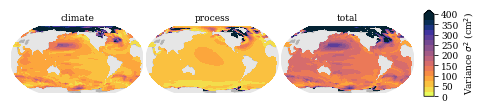

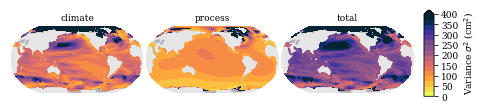

In [19]:
cmap = plt.get_cmap('cmo.thermal_r',16)
vmax = 400

for s,scen in enumerate(scens):

    fig = plt.figure()
    
    ax = fig.add_subplot(131,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,vclim[s,:,:],transform=ccrs.PlateCarree(),vmin=0,vmax=vmax,cmap=cmap)
    ax.set_title('climate')
    makeglobal(ax)
    
    ax = fig.add_subplot(132,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,vproc[s,:,:],transform=ccrs.PlateCarree(),vmin=0,vmax=vmax,cmap=cmap)
    ax.set_title('process')
    makeglobal(ax)
    
    ax = fig.add_subplot(133,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,vtot[s,:,:],transform=ccrs.PlateCarree(),vmin=0,vmax=vmax,cmap=cmap)
    ax.set_title('total')
    makeglobal(ax)
       
    cax = fig.add_axes([.87,.2,.02,.6])
    cb = plt.colorbar(im,cax=cax,extend='max')
    cb.set_label('Variance $\sigma^2$ (cm$^2$)')
    
    figname = f'draftplot_vartotal_{scen}.png'

    plt.savefig(f'../figures/{figname}',dpi=600)
    plt.savefig(f'../../../writing/codependence/figures/{figname}',dpi=600)
    plt.show()
    plt.close()